/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


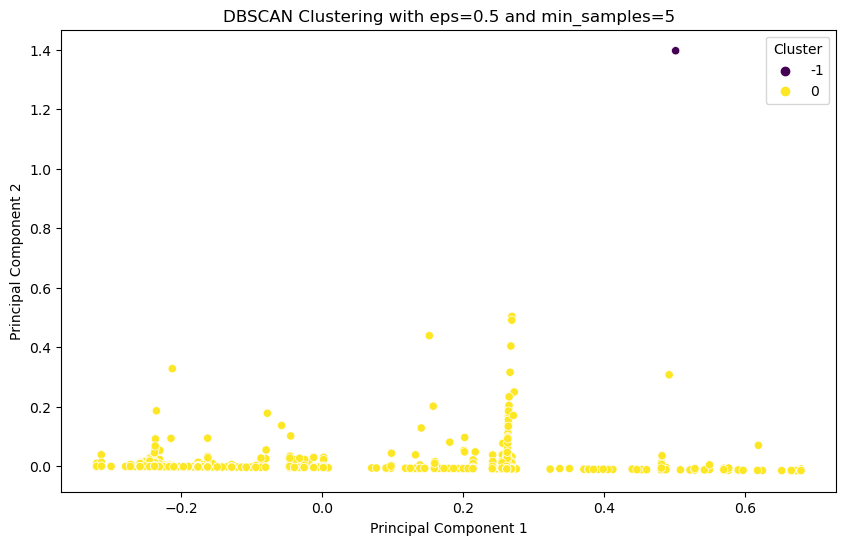

Cluster
 0    2809
-1       1
Name: count, dtype: int64


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
year = 2021
file_path = f'morans_data/{year}/basicincident_pro_{year}.csv'
df = pd.read_csv(file_path)

# 选择相关特征
df_selected = df[['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME', 'PROP_LOSS', 'CONT_LOSS', 'PROP_USE', 'PROP_VAL', 'CONT_VAL']].copy()

# 处理分类数据PROP_USE
if df_selected['PROP_USE'].dtype == 'object':
    le = LabelEncoder()
    df_selected.loc[:, 'PROP_USE'] = le.fit_transform(df_selected['PROP_USE'])

# 删除含有缺失值的样本
df_selected = df_selected.dropna()

# 进一步减少数据量，抽样比例减少到 5%
df_selected = df_selected.sample(frac=0.05, random_state=42)

# 数据归一化
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_selected), columns=df_selected.columns)

# 使用PCA进行降维（如果你希望可视化结果）
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=pca_result, columns=['principal_component_1', 'principal_component_2'])

# DBSCAN 聚类
eps = 0.5  # 你可以根据需要调整
min_samples = 5  # 你可以根据需要调整
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(pca_df)
pca_df['Cluster'] = dbscan.labels_

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='principal_component_1', y='principal_component_2', hue='Cluster', palette='viridis')
plt.title(f'DBSCAN Clustering with eps={eps} and min_samples={min_samples}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# 输出聚类标签的统计信息
cluster_counts = pca_df['Cluster'].value_counts()
print(cluster_counts)


In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import folium

# 读取火灾数据
year = 2021
file_path = f'morans_data/{year}/basicincident_pro_{year}.csv'
df = pd.read_csv(file_path)

# 读取地理信息数据（shapefile）
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 选择相关特征
df_selected = df[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME', 'PROP_LOSS', 'CONT_LOSS', 'PROP_USE', 'PROP_VAL', 'CONT_VAL']].copy()

# 处理分类数据PROP_USE
if df_selected['PROP_USE'].dtype == 'object':
    le = LabelEncoder()
    df_selected['PROP_USE'] = le.fit_transform(df_selected['PROP_USE'])

# 删除含有缺失值的样本
df_selected = df_selected.dropna()

# 确保FDID列类型一致
df_selected['FDID'] = df_selected['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 合并火灾数据和地理数据
merged_gdf = gdf.merge(df_selected, on='FDID')
# 在转换坐标系之前，随机抽样部分数据
sampled_gdf = gdf.sample(frac=0.1, random_state=42)  # 只抽取10%的数据
merged_gdf = sampled_gdf.merge(df_selected, on='FDID')

# 将几何数据转换为WGS 84坐标系
merged_gdf = merged_gdf.to_crs(epsg=4326)

# 提取每个地理区域的中心点
merged_gdf['centroid'] = merged_gdf['geometry'].centroid
merged_gdf['longitude'] = merged_gdf['centroid'].x
merged_gdf['latitude'] = merged_gdf['centroid'].y

# 确认转换后的经纬度
print(merged_gdf[['FDID', 'longitude', 'latitude']].head())

# 初始化地图
map_california = folium.Map(location=[37.5, -119.5], zoom_start=6)

# 在地图上显示所有数据点
for _, row in merged_gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=f"FDID: {row['FDID']}",
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(map_california)

# 保存地图
map_california.save('All_points_map.html')


/tmp/ipykernel_56715/1352398283.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['centroid'] = merged_gdf['geometry'].centroid


    FDID   longitude   latitude
0  28025 -122.301926  38.298487
1  28025 -122.301926  38.298487
2  28025 -122.301926  38.298487
3  28025 -122.301926  38.298487
4  28025 -122.301926  38.298487


In [4]:
# 打印 merged_gdf 数据框的前几行，检查是否有正确的经纬度数据
print(merged_gdf[['FDID', 'centroid', 'longitude', 'latitude']].head())


    FDID                       centroid     longitude       latitude
0  10005  POINT (28246.507 -132095.649)  28246.506634 -132095.649381
1  10005  POINT (28246.507 -132095.649)  28246.506634 -132095.649381
2  10005  POINT (28246.507 -132095.649)  28246.506634 -132095.649381
3  10005  POINT (28246.507 -132095.649)  28246.506634 -132095.649381
4  10005  POINT (28246.507 -132095.649)  28246.506634 -132095.649381


In [5]:
# 检查火灾数据和地理数据的 FDID
print(df_sampled['FDID'].dtype)
print(gdf['FDID'].dtype)

# 检查 FDID 匹配情况
merged_gdf = gdf.merge(df_sampled, on='FDID', how='inner')
print(merged_gdf.head())
print(f"Number of matched records: {len(merged_gdf)}")


object
object
   County   FDID MACSID       Name          Address    City    Zip  FireChief  \
0  FRESNO  10005    CLV  CLOVIS FD  1233 5TH STREET  CLOVIS  93612  CHRIS EKK   
1  FRESNO  10005    CLV  CLOVIS FD  1233 5TH STREET  CLOVIS  93612  CHRIS EKK   
2  FRESNO  10005    CLV  CLOVIS FD  1233 5TH STREET  CLOVIS  93612  CHRIS EKK   
3  FRESNO  10005    CLV  CLOVIS FD  1233 5TH STREET  CLOVIS  93612  CHRIS EKK   
4  FRESNO  10005    CLV  CLOVIS FD  1233 5TH STREET  CLOVIS  93612  CHRIS EKK   

            Phone Notes  ... Website CALFIREUni  \
0  (559) 324-2201   NaN  ...     NaN        FKU   
1  (559) 324-2201   NaN  ...     NaN        FKU   
2  (559) 324-2201   NaN  ...     NaN        FKU   
3  (559) 324-2201   NaN  ...     NaN        FKU   
4  (559) 324-2201   NaN  ...     NaN        FKU   

                                            geometry RESPONSE_TIME  \
0  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...           3.0   
1  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...

In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium

# 读取火灾数据
year = 2021
file_path = f'morans_data/{year}/basicincident_pro_{year}.csv'
df = pd.read_csv(file_path)

# 读取地理信息数据（shapefile）
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 选择相关特征
df_selected = df[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME', 'PROP_LOSS', 'CONT_LOSS', 'PROP_USE', 'PROP_VAL', 'CONT_VAL']].copy()

# 删除含有缺失值的样本
df_selected = df_selected.dropna()

# 确保FDID列类型一致
df_selected['FDID'] = df_selected['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 计算每个FDID的火灾数量
fdid_counts = df_selected.groupby('FDID').size().reset_index(name='count')

# 合并火灾数据和地理数据
merged_gdf = gdf.merge(fdid_counts, on='FDID')

# 将几何数据转换为WGS 84坐标系
merged_gdf = merged_gdf.to_crs(epsg=4326)

# 提取每个地理区域的中心点
merged_gdf['centroid'] = merged_gdf['geometry'].centroid
merged_gdf['longitude'] = merged_gdf['centroid'].x
merged_gdf['latitude'] = merged_gdf['centroid'].y

# 初始化地图
map_california = folium.Map(location=[37.5, -119.5], zoom_start=6)

# 在地图上显示数据点，点的大小根据火灾数量调整
for _, row in merged_gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['count'] / 100000000,  # 调整半径比例，根据需要调整除数以得到合适的大小
        popup=f"FDID: {row['FDID']}\nFire Count: {row['count']}",
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(map_california)

# 保存地图
map_california.save('Fire_Counts_map.html')


/tmp/ipykernel_56715/2235123506.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['centroid'] = merged_gdf['geometry'].centroid


In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
import numpy as np

# 读取火灾数据
year = 2021
file_path = f'morans_data/{year}/basicincident_pro_{year}.csv'
df = pd.read_csv(file_path)

# 读取地理信息数据（shapefile）
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 选择相关特征
df_selected = df[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME', 'PROP_LOSS', 'CONT_LOSS', 'PROP_USE', 'PROP_VAL', 'CONT_VAL']].copy()

# 删除含有缺失值的样本
df_selected = df_selected.dropna()

# 确保FDID列类型一致
df_selected['FDID'] = df_selected['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 计算每个FDID的火灾数量
fdid_counts = df_selected.groupby('FDID').size().reset_index(name='count')

# 合并火灾数据和地理数据
merged_gdf = gdf.merge(fdid_counts, on='FDID')

# 将几何数据转换为WGS 84坐标系
merged_gdf = merged_gdf.to_crs(epsg=4326)

# 提取每个地理区域的中心点
merged_gdf['centroid'] = merged_gdf['geometry'].centroid
merged_gdf['longitude'] = merged_gdf['centroid'].x
merged_gdf['latitude'] = merged_gdf['centroid'].y

# 对数缩放，或者使用平方根缩放
merged_gdf['radius'] = np.log10(merged_gdf['count'] + 1) * 5

# 或者使用平方根缩放并设置最小和最大半径
def calculate_radius(count):
    base_radius = np.sqrt(count) * 0.5
    return max(3, min(base_radius, 20))  # 设置最小半径为3，最大半径为20

merged_gdf['radius'] = merged_gdf['count'].apply(calculate_radius)

# 初始化地图
map_california = folium.Map(location=[37.5, -119.5], zoom_start=6)

# 在地图上显示数据点，点的大小根据火灾数量调整
for _, row in merged_gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['radius'],  # 使用计算后的半径
        popup=f"FDID: {row['FDID']}\nFire Count: {row['count']}",
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(map_california)

# 保存地图
map_california.save('Fire_Counts_map.html')


/tmp/ipykernel_56715/1411255681.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['centroid'] = merged_gdf['geometry'].centroid


In [6]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
import numpy as np
from matplotlib import cm

# 读取火灾数据
year = 2021
file_path = f'morans_data/{year}/basicincident_pro_{year}.csv'
df = pd.read_csv(file_path)

# 读取地理信息数据（shapefile）
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 选择相关特征
df_selected = df[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME', 'PROP_LOSS', 'CONT_LOSS', 'PROP_USE', 'PROP_VAL', 'CONT_VAL']].copy()

# 删除含有缺失值的样本
df_selected = df_selected.dropna()

# 确保FDID列类型一致
df_selected['FDID'] = df_selected['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 计算每个FDID的火灾数量
fdid_counts = df_selected.groupby('FDID').size().reset_index(name='count')

# 合并火灾数据和地理数据
merged_gdf = gdf.merge(fdid_counts, on='FDID')

# 将几何数据转换为WGS 84坐标系
merged_gdf = merged_gdf.to_crs(epsg=4326)

# 提取每个地理区域的中心点
merged_gdf['centroid'] = merged_gdf['geometry'].centroid
merged_gdf['longitude'] = merged_gdf['centroid'].x
merged_gdf['latitude'] = merged_gdf['centroid'].y

# 使用平方根缩放并设置最小和最大半径
def calculate_radius(count):
    base_radius = np.sqrt(count) * 0.5
    return max(3, min(base_radius, 20))  # 设置最小半径为3，最大半径为20

merged_gdf['radius'] = merged_gdf['count'].apply(calculate_radius)

# 为每个点分配颜色
def get_color(radius):
    if radius < 7:
        return 'green'
    elif 7 <= radius < 14:
        return 'orange'
    else:
        return 'red'

merged_gdf['color'] = merged_gdf['radius'].apply(get_color)

# 初始化地图
map_california = folium.Map(location=[37.5, -119.5], zoom_start=6)

# 在地图上显示数据点，根据火灾数量调整大小，并分配颜色
for _, row in merged_gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['radius'],
        popup=f"FDID: {row['FDID']}\nFire Count: {row['count']}",
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.6
    ).add_to(map_california)

# 保存地图
map_california.save('Fire_Counts_map_colored.html')


/tmp/ipykernel_56715/3336831683.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['centroid'] = merged_gdf['geometry'].centroid


In [7]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
import numpy as np

# 读取火灾数据
year = 2021
file_path = f'morans_data/{year}/basicincident_pro_{year}.csv'
df = pd.read_csv(file_path)

# 读取地理信息数据（shapefile）
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 选择相关特征
df_selected = df[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME', 'PROP_LOSS', 'CONT_LOSS', 'PROP_USE', 'PROP_VAL', 'CONT_VAL']].copy()

# 删除含有缺失值的样本
df_selected = df_selected.dropna()

# 确保FDID列类型一致
df_selected['FDID'] = df_selected['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 计算每个FDID的火灾数量
fdid_counts = df_selected.groupby('FDID').size().reset_index(name='count')

# 合并火灾数据和地理数据
merged_gdf = gdf.merge(fdid_counts, on='FDID')

# 将几何数据转换为WGS 84坐标系
merged_gdf = merged_gdf.to_crs(epsg=4326)

# 提取每个地理区域的中心点
merged_gdf['centroid'] = merged_gdf['geometry'].centroid
merged_gdf['longitude'] = merged_gdf['centroid'].x
merged_gdf['latitude'] = merged_gdf['centroid'].y

# 使用平方根缩放并设置最小和最大半径
def calculate_radius(count):
    base_radius = np.sqrt(count) * 0.5
    return max(3, min(base_radius, 20))  # 设置最小半径为3，最大半径为20

merged_gdf['radius'] = merged_gdf['count'].apply(calculate_radius)

# 为每个点分配颜色，范围从大到小为红、橙、黄、绿、蓝
def get_color(radius):
    if radius >= 16:
        return 'red'
    elif 12 <= radius < 16:
        return 'orange'
    elif 8 <= radius < 12:
        return 'yellow'
    elif 4 <= radius < 8:
        return 'green'
    else:
        return 'blue'

merged_gdf['color'] = merged_gdf['radius'].apply(get_color)

# 初始化地图
map_california = folium.Map(location=[37.5, -119.5], zoom_start=6)

# 在地图上显示数据点，根据火灾数量调整大小，并分配颜色
for _, row in merged_gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['radius'],
        popup=f"FDID: {row['FDID']}\nFire Count: {row['count']}",
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.6
    ).add_to(map_california)

# 保存地图
map_california.save('Fire_Counts_map_colored1.html')


/tmp/ipykernel_56715/558037774.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['centroid'] = merged_gdf['geometry'].centroid


In [3]:
import pandas as pd
import geopandas as gpd
import folium
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
import numpy as np

# 读取火灾数据
year = 2021
file_path = f'morans_data/{year}/basicincident_pro_{year}.csv'
df = pd.read_csv(file_path)
df = df.dropna().sample(frac=0.03, random_state=42)  # 减少数据量

# 读取地理信息数据（shapefile）
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 数据类型转换
df['FDID'] = df['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 使用LabelEncoder将PROP_USE转换为数值类型
le = LabelEncoder()
df['PROP_USE_ENCODED'] = le.fit_transform(df['PROP_USE'])

# 合并火灾数据和地理数据
merged_gdf = gdf.merge(df, on='FDID')
merged_gdf = merged_gdf.to_crs(epsg=4326)

# 提取每个地理区域的中心点
merged_gdf['centroid'] = merged_gdf['geometry'].centroid
merged_gdf['longitude'] = merged_gdf['centroid'].x.astype('float32')
merged_gdf['latitude'] = merged_gdf['centroid'].y.astype('float32')

# 仅使用经纬度进行聚类
dbscan = DBSCAN(eps=0.3, min_samples=10)
merged_gdf['Cluster'] = dbscan.fit_predict(merged_gdf[['longitude', 'latitude']])

# 计算圆的大小
def calculate_radius(count):
    base_radius = np.sqrt(count) * 0.5
    return max(3, min(base_radius, 15))  # 设置最小半径为3，最大半径为15

# 计算每个簇的事件数量
cluster_counts = merged_gdf.groupby('Cluster').size().reset_index(name='count')
merged_gdf = merged_gdf.merge(cluster_counts, on='Cluster', how='left')

# 为每个簇分配颜色
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'pink', 'brown', 'gray', 'black']
merged_gdf['color'] = merged_gdf['Cluster'].apply(lambda x: colors[x % len(colors)] if x != -1 else 'gray')

# 初始化地图
map_california = folium.Map(location=[37.5, -119.5], zoom_start=6)

# 在地图上显示数据点，调整大小并根据簇分配颜色
for _, row in merged_gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=calculate_radius(row['count']),
        popup=f"FDID: {row['FDID']}\nPROP_USE: {le.inverse_transform([row['PROP_USE_ENCODED']])[0]}",
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.6
    ).add_to(map_california)

# 保存地图
map_california.save('PROP_USE_DBSCAN_map_custom.html')


/tmp/ipykernel_63141/4167822711.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['centroid'] = merged_gdf['geometry'].centroid


In [8]:
import pandas as pd
import geopandas as gpd
import folium
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
import numpy as np

# 读取火灾数据
year = 2021
file_path = f'morans_data/{year}/basicincident_pro_{year}.csv'
df = pd.read_csv(file_path)
df = df.dropna().sample(frac=0.03, random_state=42)  # 减少数据量

# 读取地理信息数据（shapefile）
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 数据类型转换
df['FDID'] = df['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 使用LabelEncoder将PROP_USE转换为数值类型
le = LabelEncoder()
df['PROP_USE_ENCODED'] = le.fit_transform(df['PROP_USE'])

# 合并火灾数据和地理数据
merged_gdf = gdf.merge(df, on='FDID')
merged_gdf = merged_gdf.to_crs(epsg=4326)

# 提取每个地理区域的中心点
merged_gdf['centroid'] = merged_gdf['geometry'].centroid
merged_gdf['longitude'] = merged_gdf['centroid'].x.astype('float32')
merged_gdf['latitude'] = merged_gdf['centroid'].y.astype('float32')

# 仅使用经纬度进行聚类
dbscan = DBSCAN(eps=0.3, min_samples=10)
merged_gdf['Cluster'] = dbscan.fit_predict(merged_gdf[['longitude', 'latitude']])

# 计算圆的大小
def calculate_radius(count):
    base_radius = np.sqrt(count) * 0.5
    return max(3, min(base_radius, 15))  # 设置最小半径为3，最大半径为15

# 计算每个簇的事件数量
cluster_counts = merged_gdf.groupby('Cluster').size().reset_index(name='count')
merged_gdf = merged_gdf.merge(cluster_counts, on='Cluster', how='left')

# 为每个簇分配颜色
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'pink', 'brown', 'gray', 'black']
merged_gdf['color'] = merged_gdf['Cluster'].apply(lambda x: colors[x % len(colors)] if x != -1 else 'gray')

# 计算每个簇的数值范围
cluster_ranges = merged_gdf.groupby('Cluster')['PROP_USE_ENCODED'].agg(['min', 'max']).reset_index()

# 初始化地图
map_california = folium.Map(location=[37.5, -119.5], zoom_start=6)

# 在地图上显示数据点，调整大小并根据簇分配颜色
for _, row in merged_gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=calculate_radius(row['count']),
        popup=f"FDID: {row['FDID']}\nPROP_USE: {le.inverse_transform([row['PROP_USE_ENCODED']])[0]}",
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.6
    ).add_to(map_california)

# 添加图例，显示每个簇的数值范围
legend_html = '<div style="position: fixed; top: 50px; right: 50px; width: 250px; height: 500px; background-color: white; border:2px solid grey; z-index:9999; font-size:14px; padding: 10px;">'
legend_html += '<b>Cluster Ranges</b><br>'
for _, row in cluster_ranges.iterrows():
    color = colors[int(row['Cluster']) % len(colors)] if row['Cluster'] != -1 else 'gray'
    legend_html += f'<i style="color:{color}">●</i> Cluster {int(row["Cluster"])}: {row["min"]} - {row["max"]}<br>'
legend_html += '</div>'

map_california.get_root().html.add_child(folium.Element(legend_html))

# 保存地图
map_california.save('PROP_USE_DBSCAN_map_with_ranges_top_right.html')


/tmp/ipykernel_63141/4219681490.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['centroid'] = merged_gdf['geometry'].centroid


In [20]:
import pandas as pd
import geopandas as gpd
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np

# 读取火灾数据
year = 2021
file_path = f'morans_data/{year}/basicincident_pro_{year}.csv'
df = pd.read_csv(file_path)
df = df.dropna().sample(frac=0.03, random_state=42)  # 减少数据量

# 读取地理信息数据（shapefile）
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 数据类型转换
df['FDID'] = df['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 合并火灾数据和地理数据
merged_gdf = gdf.merge(df, on='FDID')
merged_gdf = merged_gdf.to_crs(epsg=4326)

# 提取每个地理区域的中心点
merged_gdf['centroid'] = merged_gdf['geometry'].centroid
merged_gdf['longitude'] = merged_gdf['centroid'].x.astype('float32')
merged_gdf['latitude'] = merged_gdf['centroid'].y.astype('float32')

# 特征标准化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_gdf[['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME', 'longitude', 'latitude']])

# 使用DBSCAN聚类
dbscan = DBSCAN(eps=0.8, min_samples=5)  # 调整eps和min_samples参数
merged_gdf['Cluster'] = dbscan.fit_predict(scaled_features)

# 计算每个簇的事件数量
cluster_counts = merged_gdf.groupby('Cluster').size().reset_index(name='count')
merged_gdf = merged_gdf.merge(cluster_counts, on='Cluster', how='left')

# 为每个簇分配颜色
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'pink', 'brown', 'gray', 'black']
merged_gdf['color'] = merged_gdf['Cluster'].apply(lambda x: colors[x % len(colors)] if x != -1 else 'gray')

# 调整圆的大小，使用指数运算，并设置最小半径为1
def calculate_radius(count):
    base_radius = np.log(count + 1) * 2  # 对事件数量取对数缩放
    return max(1, base_radius)  # 设置最小半径为1

# 初始化地图
map_california = folium.Map(location=[37.5, -119.5], zoom_start=6)

# 在地图上分层显示数据点，并调整透明度
for size in sorted(merged_gdf['count'].unique(), reverse=True):
    layer = folium.FeatureGroup(name=f'Cluster Size {size}')
    for _, row in merged_gdf[merged_gdf['count'] == size].iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=calculate_radius(row['count']),
            popup=f"FDID: {row['FDID']}\nPROP_USE: {row['PROP_USE']}\nCluster: {row['Cluster']}",
            color=row['color'],
            fill=True,
            fill_color=row['color'],
            fill_opacity=0.4,  # 调整透明度
            opacity=0.4  # 调整边框透明度
        ).add_to(layer)
    layer.add_to(map_california)


# 添加图层控制
folium.LayerControl().add_to(map_california)

# 保存地图
map_california.save('Cluster_Analysis_with_Transparency_and_Layers.html')


/tmp/ipykernel_63141/766795399.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['centroid'] = merged_gdf['geometry'].centroid


In [2]:
import pandas as pd
import geopandas as gpd
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np

# 读取火灾数据
year = 2021
file_path = f'morans_data/{year}/basicincident_pro_{year}.csv'
df = pd.read_csv(file_path)
df = df.dropna().sample(frac=0.03, random_state=42)  # 减少数据量进行抽样

# 读取地理信息数据（shapefile）
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 数据类型转换
df['FDID'] = df['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 合并火灾数据和地理数据
merged_gdf = gdf.merge(df, on='FDID')
merged_gdf = merged_gdf.to_crs(epsg=4326)

# 提取每个地理区域的中心点
merged_gdf['centroid'] = merged_gdf['geometry'].centroid
merged_gdf['longitude'] = merged_gdf['centroid'].x.astype('float32')
merged_gdf['latitude'] = merged_gdf['centroid'].y.astype('float32')

# 特征标准化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_gdf[['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME', 'longitude', 'latitude']])

# 使用DBSCAN聚类
dbscan = DBSCAN(eps=0.4, min_samples=10)  # 调整eps和min_samples参数以减少簇的大小
merged_gdf['Cluster'] = dbscan.fit_predict(scaled_features)

# 计算每个簇的事件数量
cluster_counts = merged_gdf.groupby('Cluster').size().reset_index(name='count')
merged_gdf = merged_gdf.merge(cluster_counts, on='Cluster', how='left')

# 为每个簇分配颜色
colors = ['#FF0000', '#FF8000', '#FFFF00', '#80FF00', '#00FF00', '#00FF80', '#00FFFF', '#0080FF', '#0000FF', '#8000FF', '#FF00FF']
merged_gdf['color'] = merged_gdf['Cluster'].apply(lambda x: colors[x % len(colors)] if x != -1 else 'gray')

# 调整圆的大小，使用指数运算，并设置最小半径为1
def calculate_radius_based_on_time(response_time, clearance_time):
    # 使用响应时间和清理时间的加权平均值来计算半径
    avg_time = (response_time + clearance_time) / 2
    base_radius = np.log(avg_time + 1) * 2  # 对事件时间取对数缩放
    return max(1, base_radius)  # 设置最小半径为1

# 初始化地图
map_california = folium.Map(location=[37.5, -119.5], zoom_start=6)

# 在地图上分层显示数据点，并调整透明度
for size in sorted(merged_gdf['count'].unique(), reverse=True):
    layer = folium.FeatureGroup(name=f'Cluster Size {size}')
    for _, row in merged_gdf[merged_gdf['count'] == size].iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=calculate_radius_based_on_time(row['RESPONSE_TIME'], row['FIRE_CLEARANCE_TIME']),
            popup=f"FDID: {row['FDID']}\nPROP_USE: {row['PROP_USE']}\nCluster: {row['Cluster']}\nResponse Time: {row['RESPONSE_TIME']}\nClearance Time: {row['FIRE_CLEARANCE_TIME']}",
            color=row['color'],
            fill=True,
            fill_color=row['color'],
            fill_opacity=0.4,  # 调整透明度
            opacity=0.4  # 调整边框透明度
        ).add_to(layer)
    layer.add_to(map_california)


# 添加图层控制
folium.LayerControl().add_to(map_california)

# 保存地图
map_california.save('Improved_Cluster_Analysis.html')


/tmp/ipykernel_183/1344469819.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['centroid'] = merged_gdf['geometry'].centroid


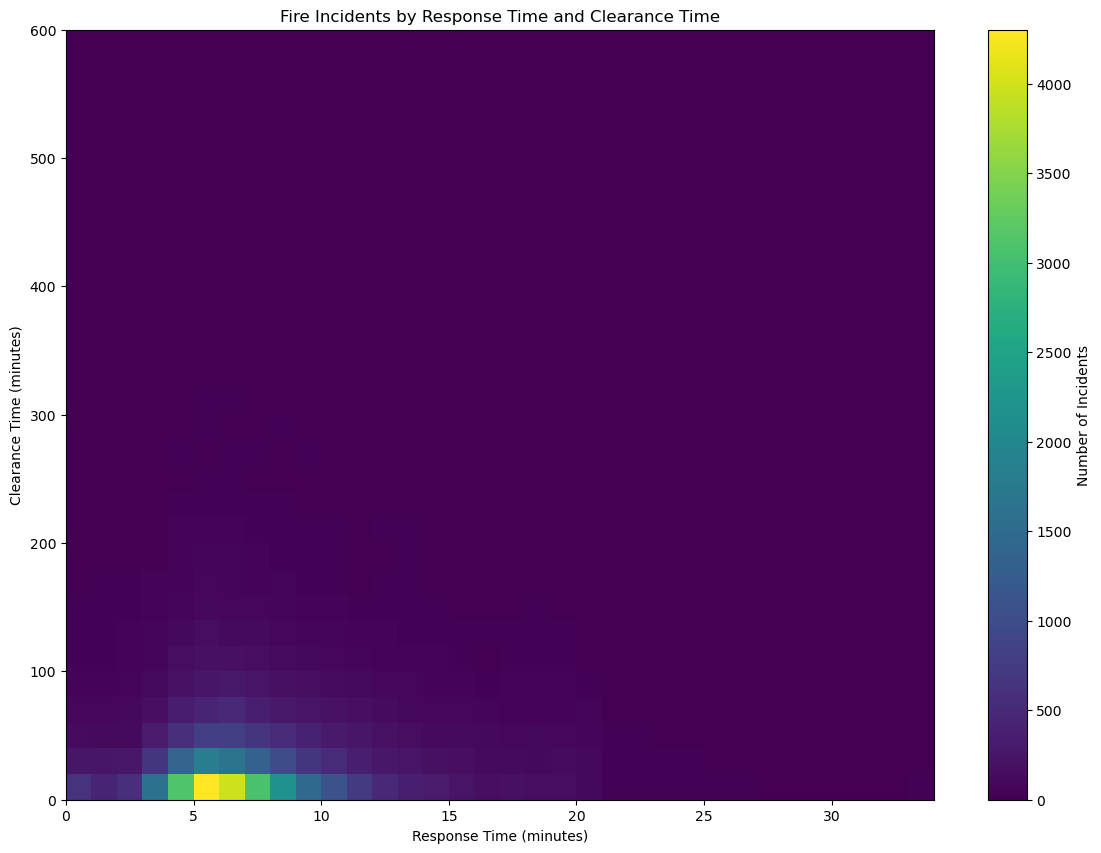

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取数据
df = pd.read_csv('morans_data/2021/basicincident_pro_2021.csv')

# 假设已经有RESPONSE_TIME和FIRE_CLEARANCE_TIME这两列
response_time = df['RESPONSE_TIME']
clearance_time = df['FIRE_CLEARANCE_TIME']

# 设置范围和区间
x_bins = np.arange(0, 35, 1)
y_bins = np.arange(0, 601, 20)

# 计算二维直方图数据
counts, xedges, yedges = np.histogram2d(response_time, clearance_time, bins=[x_bins, y_bins])

# 绘制图像
plt.figure(figsize=(14, 10))
plt.pcolormesh(xedges, yedges, counts.T, cmap='viridis', shading='auto')

# 添加颜色条
plt.colorbar(label='Number of Incidents')

# 设置轴标签
plt.xlabel('Response Time (minutes)')
plt.ylabel('Clearance Time (minutes)')
plt.title('Fire Incidents by Response Time and Clearance Time')

# 显示图像
plt.show()
